**How can we predict NCAA All-Americans using their stats?**


---



In this project, I will use a simple neural network and a logistic regression to try to predict college basketball All-Americans based on their per-possession individual and team statistics. By training models using the last 12 years of college basketball data, we can get a good understanding of what statistics are indicative of All-American level players and use this information to predict which players will be All-Americans in the 2022-23 season.

First, I will define what an All-American player is. The players that are named All-Americans are considered to be the best 15-20 players by 4 major groups. These include the Associated Press, United States Basketball Writers Association, Sporting News, and the National Association of Basketball Coaches. Each of these groups independently chooses their top 15 players of the season and places them into the first-team, second-team, or third-team. The ten players with the most votes (where votes are weighted with 3 points for first-team, 2 points for second-team, and 1 point for third-team) are given Consensus All-American honors. In this project, I chose to denote any player that received at least 1 vote as an All-American. Having more All-American players allows for more positive results in the sample, since the fraction of college basketball players that get even 1 All-American vote is extremely low. This is helpful because it is already difficult to make good models when the number of positive results is so low. 

The first step in this analysis was to install the `sportsdataverse` package, which will allow us to retrieve individual game logs from the past few seasons. After that, I imported the standard data analysis packages in addition to others that will allow us to train a neural network and a logistic regression. 

In [1]:
!pip install sportsdataverse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.0/365.0 KB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.4/158.4 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 KB 13.3 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import random
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow import keras
import sportsdataverse

Next, we must load in the player game logs that will be used to compile season stats. The `sportsdataverse.mbb.load_mbb_player_boxscore()` function will give us a dataframe including players, their teams, and box score statistics from each game. I chose to use player statistics from 2011-2022 for the sample because it is enough data without going too far back in time. 

In [3]:
player_box = sportsdataverse.mbb.load_mbb_player_boxscore(seasons = range(2011,2024))
player_box.head()

100%|██████████| 13/13 [00:18<00:00,  1.44s/it]


,athlete_display_name,team_short_display_name,min,fg,fg3,ft,oreb,dreb,reb,ast,...,team_name,team_logo,team_id,team_abbreviation,team_color,game_id,season,season_type,game_date,athlete_headshot_href
0,Gavin Gilmore,Seattle U,20,1-6,0-0,2-4,4,0,4,0,...,Redhawks,https://a.espncdn.com/i/teamlogos/ncaa/500/254...,2547,SEA,BF2E1A,303120120,2011,2,2010-11-09,None
1,Aaron Broussard,Seattle U,28,4-11,0-2,2-2,3,7,10,4,...,Redhawks,https://a.espncdn.com/i/teamlogos/ncaa/500/254...,2547,SEA,BF2E1A,303120120,2011,2,2010-11-09,None
2,Garrett Lever,Seattle U,28,2-3,0-1,2-2,1,3,4,2,...,Redhawks,https://a.espncdn.com/i/teamlogos/ncaa/500/254...,2547,SEA,BF2E1A,303120120,2011,2,2010-11-09,None
3,Cervante Burrell,Seattle U,29,6-17,0-0,1-2,0,1,1,2,...,Redhawks,https://a.espncdn.com/i/teamlogos/ncaa/500/254...,2547,SEA,BF2E1A,303120120,2011,2,2010-11-09,None
4,Sterling Carter,Seattle U,23,5-14,1-4,0-1,2,0,2,2,...,Redhawks,https://a.espncdn.com/i/teamlogos/ncaa/500/254...,2547,SEA,BF2E1A,303120120,2011,2,2010-11-09,None


Right now, the `game_date` variable is a string, but we want it as a date. Converting this variable into a date is helpful because we can establish a cut-off point. I set this date to February 8, 2023, meaning that we will only look at games that took place before this date. This will help with reproducability since the results (for 2023 only) will change after more and more games are played. 

In [4]:
CUT_OFF_DATE = '2023-02-12'

CUT_OFF_DATE = pd.to_datetime(CUT_OFF_DATE, format = "%Y-%m-%d")

player_box['game_date'] = pd.to_datetime(player_box['game_date'], format = "%Y-%m-%d")
player_box = player_box[player_box['game_date'] < CUT_OFF_DATE]

There is some more basic cleaning to do with the shooting statistics. The dataframe gives shooting stats in the form of "FGM-FGA" in one column instead of splitting this into two separate columns. The code below splits up the shooting data into shots made and shots attempted for field goals, 3-pointers, and free throws. 

In [5]:
player_box[["FGM","FGA"]] = player_box.fg.str.split("-", expand = True)
player_box[["FG3M","FG3A"]] = player_box.fg3.str.split("-", expand = True)
player_box[["FTM","FTA"]] = player_box.ft.str.split("-", expand = True)

There is also a problem with some missing data. Unfortunately, some games do not give the number of minutes played and instead use "--" to denote that the number of minutes was not captured. 

In [6]:
player_box[player_box["min"] == "--"]

,athlete_display_name,team_short_display_name,min,fg,fg3,ft,oreb,dreb,reb,ast,...,season,season_type,game_date,athlete_headshot_href,FGM,FGA,FG3M,FG3A,FTM,FTA
368134,Michael Rostampour,Omaha,--,0-2,0-1,0-0,0,2,2,1,...,2014,2,2013-11-23,None,0,2,0,1,0,0
368135,John Karhoff,Omaha,--,4-12,0-1,4-4,1,4,5,2,...,2014,2,2013-11-23,None,4,12,0,1,4,4
368136,Devin Patterson,Omaha,--,4-7,2-5,7-9,1,4,5,3,...,2014,2,2013-11-23,None,4,7,2,5,7,9
368137,Marcus Tyus,Omaha,--,6-13,3-8,1-2,0,1,1,0,...,2014,2,2013-11-23,None,6,13,3,8,1,2
368138,CJ Carter,Omaha,--,6-14,3-5,2-2,0,5,5,4,...,2014,2,2013-11-23,None,6,14,3,5,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988458,Zac Watson,UC Riverside,--,1-3,0-0,2-4,3,2,5,5,...,2019,2,2019-02-03,https://a.espncdn.com/i/headshots/mens-college...,1,3,0,0,2,4
988459,Menno Dijkstra,UC Riverside,--,4-7,0-0,2-2,0,1,1,0,...,2019,2,2019-02-03,https://a.espncdn.com/i/headshots/mens-college...,4,7,0,0,2,2
988460,DJ McDonald,UC Riverside,--,1-2,1-1,0-0,0,1,1,1,...,2019,2,2019-02-03,https://a.espncdn.com/i/headshots/mens-college...,1,2,1,1,0,0
988461,Jordan Gilliam,UC Riverside,--,5-9,1-1,4-7,5,1,6,2,...,2019,2,2019-02-03,https://a.espncdn.com/i/headshots/mens-college...,5,9,1,1,4,7


To fix this problem without removing the data with missing minutes, we can use a multiple linear regression to get a good estimation of how many minutes each player played based on his box-score stats. The dataframe originally loaded all the statistics as strings, so they need to be converted to numeric values. In addition, I converted the `starter` variable into a dummy variable so it could also be used in the regression.

In [7]:
player_box["starter"] = np.select([player_box["starter"] == True, player_box["starter"] == False],
                                   [1,0])
cols = ["min","FGM","FGA","FG3M","FG3A","FTM","FTA","oreb","dreb","ast","stl","blk","to","pf","pts"]
player_box[cols] = player_box[cols].apply(pd.to_numeric, errors='coerce')

Its important to note that missing data could be inconsistent. It is likely that some missing data for minutes played was recorded as "0" instead of "--", meaning some of are values are still off. To explore further, we can look at team-games where the total number of player minutes was 0. 

In [8]:
check_teams = player_box.groupby(["team_short_display_name","game_date"]).agg({'min': ['sum']})
check_teams.columns = ['total_min']
no_mins = check_teams[check_teams["total_min"] == 0]
print(no_mins.shape)
print(no_mins.head())

(70, 1)
                                    total_min
team_short_display_name game_date            
Akron                   2019-02-13        0.0
Arizona                 2014-03-08        0.0
Arkansas                2014-11-26        0.0
Austin Peay             2013-11-23        0.0
Belmont                 2018-11-24        0.0


Now that we know what data is missing, we can start to create the data to train the minutes regression. The model can be trained by the players who did not have missing data. 

In [9]:
player_box = player_box.merge(check_teams, on = ['team_short_display_name','game_date'], how = 'left')

In [10]:
minutes_est = player_box[["min","FGA","FG3A","FTA","oreb","dreb","ast","stl","blk","to","pf","starter","total_min"]]
minutes_est_train = minutes_est[(minutes_est['min'].isnull() == False) & (minutes_est['total_min'] != 0)]
minutes_est_train = minutes_est_train.drop(["total_min"], axis = 1)

Now that the data is ready for use, we can use it to model the minutes played in a game. The code below separates the independent variables from the dependent variables and fits the linear regression.

In [11]:
mins_x = np.array(minutes_est_train)[:, 1:12]
mins_y = np.array(minutes_est_train)[:, 0]

min_fit = LinearRegression()
min_fit.fit(mins_x, mins_y)

LinearRegression()

To get the estimated minutes played for those missing the data, we just apply the predictions from the linear regression to the dataset and allow the `min` variable to be the actual minutes if it was recorded. Otherwise, we use the expected minutes from the regression if it is missing. The first code chunk shows that the predicted minutes array has the same length as the number of rows from the box scores dataframe. Therefore we can add it on to the box scores dataframe. The second code chunk converts the variables to numeric and substitutes the expected minutes for `min` for players with missing minutes data. It also shows that there is no more missing data for `min` after this.

In [12]:
predicted_mins = min_fit.predict(np.array(minutes_est)[:, 1:12])
print(predicted_mins.shape)
print(player_box.shape)

(1464572,)
(1464572, 41)


In [13]:
player_box["yhat_min"] = predicted_mins

player_box["min"] = np.select([(player_box["min"].isnull()) | (player_box["total_min"] == 0)],
                              [player_box["yhat_min"]],
                              default = player_box['min'])

print(player_box[player_box["min"].isnull()])


Empty DataFrame
Columns: [athlete_display_name, team_short_display_name, min, fg, fg3, ft, oreb, dreb, reb, ast, stl, blk, to, pf, pts, starter, ejected, did_not_play, active, athlete_jersey, athlete_id, athlete_short_name, athlete_position_name, athlete_position_abbreviation, team_name, team_logo, team_id, team_abbreviation, team_color, game_id, season, season_type, game_date, athlete_headshot_href, FGM, FGA, FG3M, FG3A, FTM, FTA, total_min, yhat_min]
Index: []

[0 rows x 42 columns]


The data is now clean for the most part. To do the analysis, I want to use per-possession stats in order to decrease the effects of pace and playing time on the results. The number of possessions played can be estimated by taking the proportion of minutes played and multiplying by team possessions (which is roughly given by FGA + 0.4*FTA + TOV - OREB).

In [14]:
team_poss = player_box.groupby(["team_short_display_name","game_date"])[["min","FGA","to","oreb","FTA"]].sum()
team_poss.columns = ['tm_min','tm_FGA','tm_TOV','tm_OREB','tm_FTA']
player_box = player_box.merge(team_poss, on = ["team_short_display_name","game_date"], how = 'left')
player_box = player_box.assign(Est_Poss = lambda x: x["min"]/(x["tm_min"]/5) * (x['tm_FGA'] + x['tm_TOV'] - x['tm_OREB'] + 0.4*x['tm_FTA']))

The following code calculates the sum of the given variables below for each player in each season to get their season stats. Then the variables are renamed. 

In [15]:
sum_cols = ["Est_Poss","min","FGM","FGA","FG3M","FG3A","FTM","FTA","oreb","dreb","ast","stl","blk","to","pf","pts"]

players = player_box.groupby(["athlete_display_name","team_short_display_name","season"], as_index = False)[sum_cols].sum()
players = players.rename({"athlete_display_name" : "Player", "team_short_display_name" : "School", "season" : "Season",
                          "Est_Poss" : "POSS", "min" : "MIN", "oreb" : "OREB", "dreb" : "DREB", "ast" : "AST", 
                          "stl" : "STL", "blk" : "BLK", "to" : "TOV", "pf" : "PF", "pts" : "PTS"}, axis = 1)

The next thing to do is get the team statistics. I chose to use some of KenPom's efficiency statistics to get a good measure of team quality. The `kp_mapping` dataset provides a conversion from the team names of the espn box score data to the team names of the KenPom data. The `school_stats` data includes team efficiency stats as of February 11, 2023. (Note: I gathered the KenPom data using the `kp_pomeroy_ratings` function from the `hoopR` package in R; all this data is available without a KenPom subscription)

In [16]:
school_stats = pd.read_csv("https://raw.githubusercontent.com/AyushBatra15/All-Americans/main/kp_team.csv")
kp_mapping = pd.read_csv("https://raw.githubusercontent.com/AyushBatra15/All-Americans/main/kp_mapping.csv")

The KenPom data comes with win-loss record as a string with wins and losses separated by a hyphen. To get a win-loss percentage, I split the win loss column into 2 separate variables, made them numeric, then calculated team games played and win percentage. Lastly, I selected only the relevant variables. 

In [17]:
school_stats[["W","L"]] = school_stats.w_l.str.split("-", expand = True)
school_stats[["W","L"]] = school_stats[["W","L"]].apply(pd.to_numeric, errors = "coerce")
school_stats = school_stats.assign(games = lambda x: x["W"] + x["L"])
school_stats = school_stats.assign(WP = lambda x: x["W"]/x["games"])
school_stats = school_stats[["rk","team","year","games","WP","adj_o","adj_d","adj_t","sos_opp_o","sos_opp_d"]]

After looking through the both the KenPom data and the espn box score data, it occurred to me that almost all of the state schools have "St." instead of "State" in their KenPom name. To create some matches, I added a period to school names that ended in "St" in the espn data. In addition, I converted any schools that had "State" in their name to have "St." instead. 

In [18]:
players["School"] = np.select([players["School"].str[-2:] == "St"],
                              [players["School"] + "."],
                              default = players["School"])

In [19]:
players["School"] = players["School"].str.replace("State", "St.")

There are some matches in the KenPom school names and ESPN school names without further editing. Therefore, we can merge these datasets for at least some players. However, there are still schools like UMass, Western KY, and Cent Michigan without matches in the KenPom data. This is where the `kp_mapping` dataset comes into play.

In [20]:
players = players.merge(school_stats, left_on = ["School","Season"], right_on = ["team","year"], how = 'left')

In [21]:
no_match = players[players['rk'].isnull()]
no_match.sort_values(by = 'POSS', ascending = False)

,Player,School,Season,POSS,MIN,FGM,FGA,FG3M,FG3A,FTM,...,rk,team,year,games,WP,adj_o,adj_d,adj_t,sos_opp_o,sos_opp_d
17093,Chaz Williams,UMass,2012,2383.608444,1291.0,195,476,62,148,175,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24410,Darius Thompson,Western KY,2018,2345.272778,1354.0,177,382,54,152,109,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11413,Braylon Rayson,Cent Michigan,2017,2306.234444,1192.0,209,548,93,257,168,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67879,Marcus Keene,Cent Michigan,2017,2280.760556,1179.0,313,701,125,341,208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91599,Taveion Hollingsworth,Western KY,2018,2273.971944,1312.0,170,354,45,119,121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32795,Elijah Watson,UT Rio Grande,2014,0.000000,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19663,Cody Mann,Florida Int'l,2015,0.000000,0.0,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51320,John Walker,Brewton-Parker,2015,0.000000,0.0,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63315,La'Darius Carter,Miles,2018,0.000000,0.0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The `no_match` data includes players whose teams do not have a match with the KenPom data yet. In this dataframe, I used the `kp_mapping` dataset I created to get the KenPom names for the schools without a match. Lastly, I had to drop any rows with `NA` because these rows were for players that played for non-D1 teams. 

In [22]:
no_match = no_match.iloc[:, 0:19]
no_match = no_match.merge(kp_mapping, left_on = ["School"], right_on = ["hoopr"], how = 'left')
no_match["School"] = no_match["kenpom"]
no_match = no_match.drop(["kenpom","hoopr"], axis = 1)
no_match = no_match.merge(school_stats, left_on = ["School","Season"], right_on = ["team","year"], how = 'left')
no_match = no_match.dropna()

And now the dataframes could be put together to get all the D1 players' team stats. 

In [23]:
players = players.dropna()
players = pd.concat([players, no_match], axis = 0)

The `winners` data includes the players that received at least 1 All-American vote for each season. Since all these players are All-Americans, I set the `All_American` dummy equal to 1, joined it with the player stats data, and allowed all other players to have 0 for `All_American`. 


In [24]:
winners = pd.read_csv("https://raw.githubusercontent.com/AyushBatra15/All-Americans/main/allamericans.csv")

In [25]:
winners = winners.assign(All_American = 1)
winners = winners.rename({"season" : "Season"}, axis = 1)

In [26]:
per100 = players.merge(winners, on = ["Player","School","Season"], how = 'left')
per100["All_American"] = np.select([per100["All_American"].isnull()],
                                   [0], default = per100["All_American"])

Next, I calculated the Minutes Percentage by taking the minutes and dividing by available minutes. This value won't be exact since there is some inaccuracy in the box score data and because I used 40 for minutes per game when in reality this value should be slightly larger for some teams due to overtime games. I also dropped some columns that aren't necessary. 

In [27]:
per100 = per100.assign(MIN_P = lambda x: x["MIN"]/(40*x["games"]))
per100 = per100.drop(["rk","PTS","games"], axis = 1)

Using per-possessions stats is the best way to measure player performance without influence from playing time and team pace. I chose to represent each box score stat in a scale of per 100 possessions, I took the value of the stat, divided by the number of possessions, and multiplied by 100. 

In [28]:
def scale100(stat, poss):
  return stat/poss*100

per100 = per100.assign(FGM = lambda x: scale100(x["FGM"], x["POSS"]))
per100 = per100.assign(FGA = lambda x: scale100(x["FGA"], x["POSS"]))
per100 = per100.assign(FG3M = lambda x: scale100(x["FG3M"], x["POSS"]))
per100 = per100.assign(FG3A = lambda x: scale100(x["FG3A"], x["POSS"]))
per100 = per100.assign(FTM = lambda x: scale100(x["FTM"], x["POSS"]))
per100 = per100.assign(FTA = lambda x: scale100(x["FTA"], x["POSS"]))
per100 = per100.assign(OREB = lambda x: scale100(x["OREB"], x["POSS"]))
per100 = per100.assign(DREB = lambda x: scale100(x["DREB"], x["POSS"]))
per100 = per100.assign(AST = lambda x: scale100(x["AST"], x["POSS"]))
per100 = per100.assign(STL = lambda x: scale100(x["STL"], x["POSS"]))
per100 = per100.assign(BLK = lambda x: scale100(x["BLK"], x["POSS"]))
per100 = per100.assign(TOV = lambda x: scale100(x["TOV"], x["POSS"]))
per100 = per100.assign(PF = lambda x: scale100(x["PF"], x["POSS"]))

Now that the data is ready. I split it up into the players from 2011-2022 and the players in 2023. None of the 2023 players have actually been named All-Americans yet, so this data is only for predictions to be made on. 

In [29]:
data23 = per100[per100["Season"] == 2023]
df = per100[per100["Season"] != 2023]
data23 = data23.drop(["All_American"], axis = 1)

But what should be the minutes cut-off? To find the best minutes cut-off, we can look at the distribution of minutes percentage for players that received at least 1 All-American vote. 

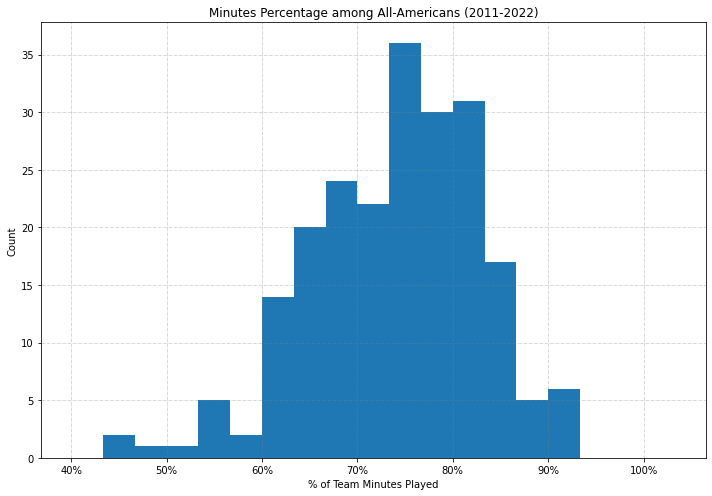

In [30]:
aa_mins = df[df.All_American == 1]
aa_mins = aa_mins["MIN_P"]
binsList = np.arange(0.4,1 + 1/30,1/30).tolist()

fig, ax = plt.subplots(1,1, figsize = (10,7), tight_layout = True)
ax.hist(aa_mins, bins = binsList)
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))
plt.title("Minutes Percentage among All-Americans (2011-2022)")
plt.xlabel("% of Team Minutes Played")
plt.ylabel("Count")
plt.show()

From the hisotgram, we can see that most All-Americans played between 65% and 85% of their teams' minutes. However, all All-Americans played at least 40% of available minutes. Therefore, I set the cut-off for minutes% at 40%. 

In [31]:
df = df[df["MIN_P"] > 0.4]
data23 = data23[data23["MIN_P"] > 0.4]

To get a rough overview of how All-Americans perform against their peers, we can look at the average per-100 stats for All-Americans vs non All-Americans. The output below suggest what one would expect. All-Americans score more points, grab more rebounds, get more assists, have a greater defensive impact, and better team performance. 

In [32]:
df["PTS"] = 2*df["FGM"] + df["FG3M"] + df["FTM"]
df.groupby('All_American')[["PTS","OREB","DREB","AST","STL","BLK","WP","adj_o","adj_d"]].mean()

,PTS,OREB,DREB,AST,STL,BLK,WP,adj_o,adj_d
All_American,,,,,,,,,
0.0,21.374514,2.580417,6.798870,3.969125,1.897389,0.970075,0.507063,103.558057,103.689325
1.0,33.114435,3.093603,8.822035,5.410625,2.174084,1.469974,0.789471,117.346759,93.777315


In [33]:
df["All_American"] = np.select([df["All_American"] == 1, df["All_American"] == 0], 
                               ["Yes","No"])

To get a better idea of the scoring difference between All-Americans and those who aren't All-Americans, one can look at the boxplot of scoring distributions. 

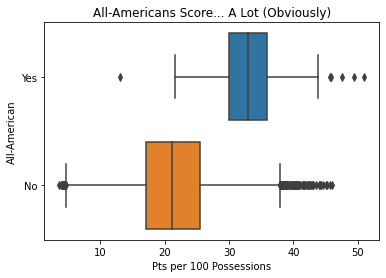

In [34]:
pts_boxplot = sns.boxplot(data = df, x = 'PTS', y = 'All_American', orient = 'h',
                          order = ["Yes","No"])
pts_boxplot.set(xlabel = "Pts per 100 Possessions", 
                ylabel = "All-American",
                title = "All-Americans Score... A Lot (Obviously)")
plt.show()
sns.set_style("ticks",{'axes.grid' : True})

In [35]:
df[(df["All_American"] == "Yes") & (df["PTS"] < 20)]

,Player,School,Season,POSS,MIN,FGM,FGA,FG3M,FG3A,FTM,...,year,WP,adj_o,adj_d,adj_t,sos_opp_o,sos_opp_d,All_American,MIN_P,PTS
28458,Kendall Marshall,North Carolina,2012,2025.355,1121.0,4.591788,10.368553,1.283726,3.752429,2.567451,...,2012.0,0.842105,116.1,90.7,70.9,107.2,99.8,Yes,0.7375,13.034752


The boxplot shows that the middle 50% of All-American scoring lies between 30 and about 36 points per 100 possessions, much greater than about 17 and 25, respectively, for non All-Americans. In fact, all but 1 All-American player (Kendall Marshall in 2012) scored over 20 points per 100 possessions, which translates to about 10 points in 30 minutes of a game at average pace. 

We can also look at rebounding:

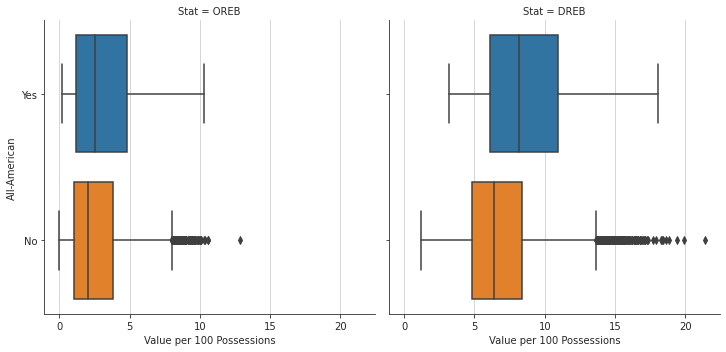

In [36]:
reb_df = df[["Player","All_American","OREB","DREB"]]
reb_df = pd.melt(reb_df, id_vars = ["Player","All_American"],
                 value_vars = ["OREB","DREB"])
reb_df = reb_df.rename({"variable" : "Stat", "value" : "Per100"}, axis = 1)
reb_df
reb_boxplot = sns.catplot(data = reb_df, x = "Per100", y = "All_American", col = "Stat",
                          kind = 'box', orient = 'h', order = ["Yes","No"],
                          col_wrap = 3)
reb_boxplot.set(xlabel = "Value per 100 Possessions",
                ylabel = "All-American")
plt.show()

Rebounding is much less predictive of All-Americans than scoring. Although All-Americans typically get slightly more offensive rebounds and defensive rebounds, the difference is not very lage. In fact, there is a large overlap in the boxes representing the middle 50% of rebounding for All-Americans and non All-Americans. 

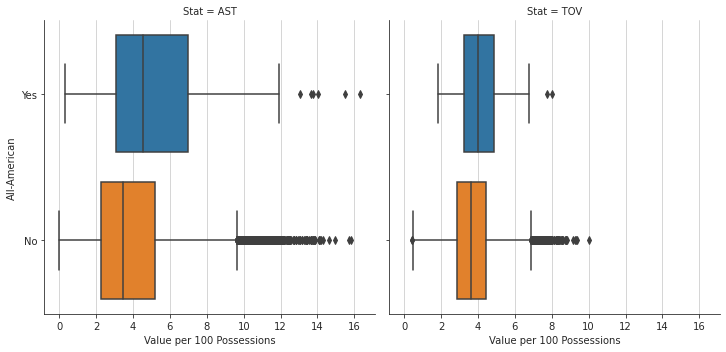

In [37]:
playm_df = df[["Player","All_American","AST","TOV"]]
playm_df = pd.melt(playm_df, id_vars = ["Player","All_American"],
                   value_vars = ["AST","TOV"])
playm_df = playm_df.rename({"variable" : "Stat", "value" : "Per100"}, axis = 1)
playm_df
playm_boxplot = sns.catplot(data = playm_df, x = "Per100", y = "All_American", col = "Stat",
                            kind = 'box', orient = 'h', order = ["Yes","No"],
                            col_wrap = 3)
playm_boxplot.set(xlabel = "Value per 100 Possessions",
                  ylabel = "All-American")
plt.show()

We can look at playmaking statistics like assists and turnovers as well. Neither statistic looks to be nearly as predictive as points, but All-Americans still have a greater median assists per 100. Even though turnovers are seen as a bad thing, All-Americans usually have more of them than non All-Americans. The reason for this is that All-Americans usually have much higher usage rates, meaning they have the ball in their hands more often giving them more chances to turn the ball over. 

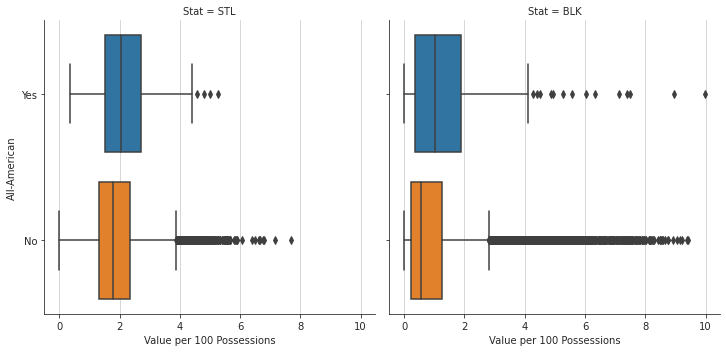

In [38]:
def_df = df[["Player","All_American","STL","BLK"]]
def_df = pd.melt(def_df, id_vars = ["Player","All_American"],
                 value_vars = ["STL","BLK"])
def_df = def_df.rename({"variable" : "Stat", "value" : "Per100"}, axis = 1)
def_df
def_boxplot = sns.catplot(data = def_df, x = "Per100", y = "All_American", col = "Stat",
                          kind = 'box', orient = 'h', order = ["Yes","No"],
                          col_wrap = 3)
def_boxplot.set(xlabel = "Value per 100 Possessions",
                ylabel = "All-American")
plt.show()

All-American players typically perform better than average on the defensive side of the ball. Blocks seem to be more predictive of All-Americans than steals are, meaning that the public likely values rim protectors over perimeter players that can intercept passing lanes. 

One would expect that All-American shoot more efficient than other players. The following code helps to produce a dataset that can make a visualization to test this theory. To ensure players who took few shots were excluded, I ensured that the included players must have over 50 attempts when counted for field goal attempts, 3-point attempts, or free throw attempts. 

In [39]:
shot_df1 = df.assign(FG = lambda x: x["FGA"]*x["POSS"]/100)
shot_df1 = shot_df1.assign(FG3 = lambda x: x["FG3A"]*x["POSS"]/100)
shot_df1 = shot_df1.assign(FT = lambda x: x["FTA"]*x["POSS"]/100)
shot_df1 = shot_df1[["Player","School","Season","All_American","FG","FG3","FT"]]
shot_df1 = pd.melt(shot_df1, id_vars = ["Player","School","Season","All_American"],
                   value_vars = ["FG","FG3","FT"], var_name = "Type", value_name = "Total")

shot_df2 = df.assign(FG = lambda x: x["FGM"]/x["FGA"])
shot_df2 = shot_df2.assign(FG3 = lambda x: x["FG3M"]/x["FG3A"])
shot_df2 = shot_df2.assign(FT = lambda x: x["FTM"]/x["FTA"])
shot_df2 = shot_df2[["Player","School","Season","All_American","FG","FG3","FT"]]
shot_df2 = pd.melt(shot_df2, id_vars = ["Player","School","Season","All_American"],
                   value_vars = ["FG","FG3","FT"], var_name = "Type", value_name = "FGP")

shot_df = pd.merge(shot_df1, shot_df2, on = ["Player","School","Season","All_American","Type"])
shot_df = shot_df[shot_df["Total"] >= 50]

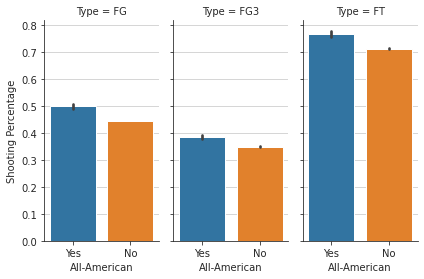

In [40]:
shot_barplot = sns.catplot(data = shot_df, x = "All_American", y = "FGP", col = "Type",
                           kind = 'bar', order = ["Yes","No"],
                           height = 4, aspect = 0.5)
shot_barplot.set(xlabel = "All-American",
                 ylabel = "Shooting Percentage")
plt.show()

Indeed, All-Americans do shoot better than other players. The average field goal percentage for All-American players was close to 50%, while other were closer to 40-45%. In addition, All-American players that shot at least 50 3-point attempts had an average 3P% close to 38%. Free throws were also important as All-Americans shot an average of over 75% from the line. 

Next, we can look at team efficiency metrics and strength of schedule:

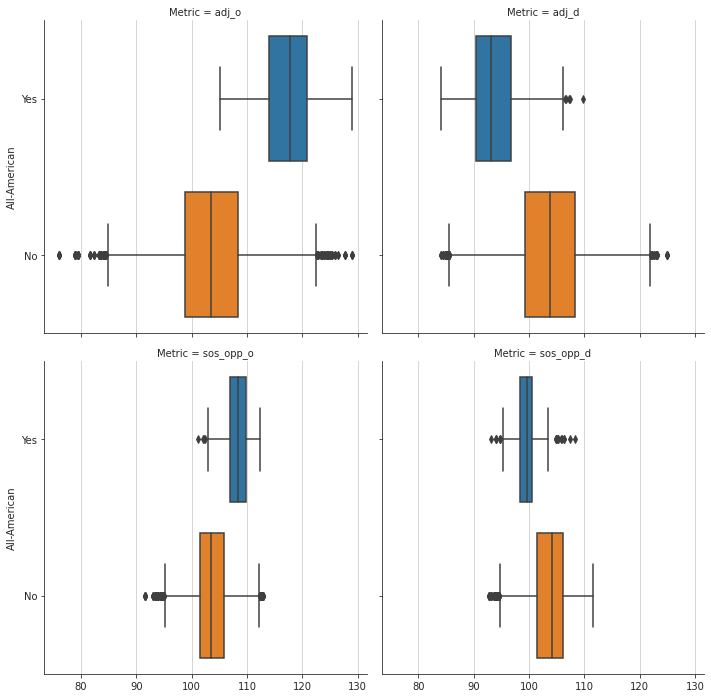

In [41]:
tm_df = df[["Player","All_American","adj_o","adj_d","sos_opp_o","sos_opp_d"]]
tm_df = pd.melt(tm_df, id_vars = ["Player","All_American"],
                 value_vars = ["adj_o","adj_d","sos_opp_o","sos_opp_d"])
tm_df = tm_df.rename({"variable" : "Metric", "value" : "Value"}, axis = 1)
tm_boxplot = sns.catplot(data = tm_df, x = "Value", y = "All_American", col = "Metric",
                          kind = 'box', orient = 'h', order = ["Yes","No"],
                          col_wrap = 2)
tm_boxplot.set(xlabel = "",
                ylabel = "All-American")
plt.show()

NOTE: A lower defensive efficiency (adj_d) is better as it means the team is allowing fewer points per 100 possessions. The same logic follows for defensive strength of schedule (sos_opp_d)

Team strength seems to have a large effect on the selection of All-American players. Almost all All-Americans are on teams that are among the top in the country, especially on offense. In fact, every single player that received at least 1 All-American vote since 2011 has been on an team with an adjusted offensive efficiency above the median. Defense is also important, but there were still some All-American players from below average defensive teams. Strength of schedule also plays a role, as All-American players played a tougher schedule than average. For those that watch college basketball, this is obvious as almost all All-American players come from teams that are top-8 seeds in the NCAA Tournament (implying they are among the top 32 teams in the country). 

The two most important variables in predicting All-Americans seem to be points and team quality. Let's see how we can combine these variables to get an idea of what a typical All-American's profile is. 

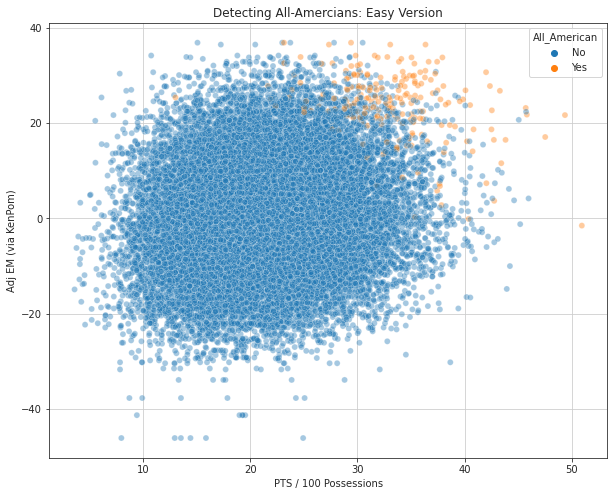

In [42]:
scat_df = df.assign(adj_em = lambda x: x["adj_o"] - x["adj_d"])

fig = plt.gcf()
fig.set_size_inches(10,8)
scatter = sns.scatterplot(data = scat_df, x = "PTS", y = "adj_em",
                          hue = "All_American", alpha = 0.4)
scatter.set(xlabel = "PTS / 100 Possessions",
            ylabel = "Adj EM (via KenPom)",
            title = "Detecting All-Amercians: Easy Version")
plt.show()

The scatterplot above implies that most All-Americans are very good scorers and are on a very good team. It seems like a player needs to score at least 30 points per 100 or have an adjusted efficiency margin (adjusted offense - adjusted defense) above 20 to even have a chance of being an All-American. 

To get probablistic predictions, we can train a neural network. First I dropped the unnecessary columns. We don't need to include points because it can be computed with 2-point makes, 3-point makes, and free throw makes, all of which are in the data. In addition, I reconverted the `All_American` variable to a numeric so it can be predicted. 

In [43]:
df = df.drop(["POSS","MIN","PTS","team","year"], axis = 1)
df = df.assign(FG2M = lambda x: x["FGM"] - x["FG3M"])
df = df.assign(FG2A = lambda x: x["FGA"] - x["FG3A"])
df["All_American"] = np.select([df["All_American"] == "Yes", df["All_American"] == "No"], 
                               [1,0])

Next, I set random seeds so that the results are reproducable and selected the columns that I wanted to keep. 

In [44]:
SEED = 100
SEED2 = 200

In [45]:
#Choose variables we want to use to predict:

new_df = df[["Player","School","Season","FG2M","FG2A","FG3M","FG3A","FTM","FTA","OREB","DREB","AST",
             "TOV","STL","BLK","WP","adj_o","adj_d","sos_opp_o","sos_opp_d","All_American"]]

Then, I split the data into a training set, validation set, and test set. I put 70% of the data in the training set, 15% in the validation set, and 15% in the test set. 

In [46]:
train_df = new_df.sample(frac = 0.70, random_state = SEED)
rest = new_df.drop(train_df.index)
val_df = rest.sample(frac = 0.5, random_state = SEED2)
test_df = rest.drop(val_df.index)

In [47]:
train_successes = train_df['All_American'].sum()
train_percent = round(100*train_successes/len(train_df),2)
print("Train Successes: " + str(train_successes) + "/" + str(len(train_df)) + " (" + str(train_percent) + "%)")

val_successes = val_df['All_American'].sum()
val_percent = round(100*val_successes/len(val_df),2)
print("Validation Successes: " + str(val_successes) + "/" + str(len(val_df)) + " (" + str(val_percent) + "%)")

test_successes = test_df['All_American'].sum()
test_percent = round(100*test_successes/len(test_df),2)
print("Test Successes: " + str(test_successes) + "/" + str(len(test_df)) + " (" + str(test_percent) + "%)")

Train Successes: 152/17837 (0.85%)
Validation Successes: 31/3822 (0.81%)
Test Successes: 33/3822 (0.86%)


In [48]:
train_df.head()

,Player,School,Season,FG2M,FG2A,FG3M,FG3A,FTM,FTA,OREB,...,AST,TOV,STL,BLK,WP,adj_o,adj_d,sos_opp_o,sos_opp_d,All_American
186,AJ Sumbry,Wagner,2019,7.871882,17.010504,0.000000,0.271444,5.428884,9.500548,5.700329,...,0.633370,3.709738,0.633370,3.619256,0.433333,93.9,107.5,101.4,108.7,0
258,Aaron Bright,Saint Mary's,2015,3.947205,9.595791,2.994431,9.868012,5.444420,6.193028,0.612497,...,7.690244,4.627757,1.020829,0.000000,0.677419,110.9,100.6,106.7,104.3,0
3042,Antwon Lillard,Bowling Green,2016,7.380942,12.166388,1.297748,4.785446,4.947664,7.867597,3.082152,...,1.703294,3.568807,2.027731,0.729983,0.470588,100.9,106.7,104.7,106.2,0
51358,Chaz Williams,Massachusetts,2012,5.579776,13.760649,2.601098,6.209073,7.341810,9.313610,1.510315,...,9.691189,5.286103,3.398209,0.293672,0.675676,106.2,96.3,105.0,101.2,0
7289,Carsen Edwards,Purdue,2018,7.134177,13.855633,5.247452,12.735390,7.016257,8.667141,0.766482,...,6.013934,3.537608,2.358406,0.471681,0.810811,122.7,96.4,109.1,100.1,1


Now we can begin to train the network. I turned the data into an array and separated the data into predictors and the dependent variable. In addition, I standardized all the data so that units do not have an impact. This process was repeated for the validation and test sets. I also set seeds so that the results from the neural network are reproducible. 

In [49]:
blind_df = train_df.drop(["Player","School","Season"], axis = 1)
arr_data = np.array(blind_df)

ncol = arr_data.shape[1]
train_x = arr_data[:, 0 : ncol - 1]
train_y = arr_data[:, ncol - 1]

#Standardize all input values so they have a mean of 0 and standard deviation of 1
st_train_x = (train_x - np.mean(train_x, axis = 0))/np.std(train_x, axis = 0)

val_array = np.array(val_df.drop(["Player","School","Season"], axis = 1))
val_x = val_array[:, 0 : ncol - 1]
val_y = val_array[:, ncol - 1]

st_val_x = (val_x - np.mean(val_x, axis = 0))/np.std(val_x, axis = 0)

test_array = np.array(test_df.drop(["Player","School","Season"], axis = 1))
test_x = test_array[:, 0 : ncol - 1]
test_y = test_array[:, ncol - 1]

st_test_x = (test_x - np.mean(test_x, axis = 0))/np.std(test_x, axis = 0)

In [50]:
SEED_VAL = 123
random.seed(SEED_VAL)
np.random.seed(SEED_VAL)
tf.random.set_seed(SEED_VAL)

I chose to use a neural network with 1 hidden layer. This hidden layer has 5 nodes. I played around with the number of nodes in the hidden layer and found that 5 nodes produced the best results in the validation set. Adding more layers did not provide any more accurate predictions on the validation set, so its possible that adding more hidden layers led to overfitting in the model. Therefore, the final model has 1 hidden layer with 5 nodes. The sigmoid activation function is needed for the final step because the outputs needed to be probabilities. 

Other hyperparameters included the number of epochs and batch size. After varying these parameters, I found that the best results came when the number of epochs was 30 and the batch size was 32. Increasing the epochs led to inaccurate validation set predictions as the model was likely overfit. Although increasing the batch size led to faster training, it resulted in worse predictions. I also tried reducing the batch size but the validation set results were still not as good.

In [51]:
nn = keras.Sequential([
    keras.layers.Dense(units = 5, input_shape = (17,), activation = 'relu'),
    keras.layers.Dense(units = 1, activation = 'sigmoid')
])

In [52]:
nn.compile(optimizer = 'adam', 
           loss = 'binary_crossentropy',
           metrics = ['accuracy'])

history = nn.fit(st_train_x, train_y, epochs = 30, batch_size = 32)

Epoch 1/30
558/558 [==============================] - 2s 2ms/step - loss: 0.2767 - accuracy: 0.9059
Epoch 2/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0727 - accuracy: 0.9915
Epoch 3/30
558/558 [==============================] - 2s 3ms/step - loss: 0.0500 - accuracy: 0.9916
Epoch 4/30
558/558 [==============================] - 2s 3ms/step - loss: 0.0408 - accuracy: 0.9917
Epoch 5/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0352 - accuracy: 0.9920
Epoch 6/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0311 - accuracy: 0.9921
Epoch 7/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0274 - accuracy: 0.9922
Epoch 8/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0243 - accuracy: 0.9929
Epoch 9/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0224 - accuracy: 0.9930
Epoch 10/30
558/558 [==============================] - 1s 2ms/step - loss: 0.0208 - accuracy: 0.9930

Let's see some of the output of the neural network on the training set. This set included most of the data. A peak at the results below shows that it gave extremely high probabilities to players that were considered easy All-American picks. Among the 5 players with the greatest All-American probability in the training set, 4 were named First-Team All-Americans in all 4 sites used to compile the consensus All-Americans. 

In [53]:
train_pred = nn.predict(st_train_x)
train_df["phat_nn"] = train_pred
train_results = train_df[train_df["phat_nn"] >= 0.5]
train_results = train_results[["Player","Season","School","All_American","phat_nn"]]
train_results = train_results.sort_values(by = "phat_nn", ascending = False)
train_results

558/558 [==============================] - 1s 2ms/step


,Player,Season,School,All_American,phat_nn
16803,Frank Kaminsky,2015,Wisconsin,1,0.995866
21941,Jared Butler,2021,Baylor,1,0.989195
7463,Cassius Winston,2019,Michigan St.,1,0.986382
23718,Jimmer Fredette,2011,BYU,1,0.976367
26120,Josh Hart,2017,Villanova,1,0.965286
...,...,...,...,...,...
3804,Azuolas Tubelis,2022,Arizona,0,0.513147
21940,Jared Butler,2020,Baylor,1,0.512301
18517,Hunter Dickinson,2021,Michigan,1,0.507464
22221,Jarron Cumberland,2019,Cincinnati,0,0.503742


We can also take a look at the validation set. The root mean squared error was 0.076. Both of the players with an All-American probability greater than 90% (RJ Barrett and Trey Burke) were on the first-team for all 4 sites. 

In [54]:
val_pred = nn.predict(st_val_x)
val_df["phat_nn"] = val_pred
val_results = val_df[val_df["phat_nn"] >= 0.5]
val_results = val_results[["Player","Season","School","All_American","phat_nn"]]
val_results = val_results.sort_values(by = "phat_nn", ascending = False)
print(val_results.head())
val_RMSE = ((val_df.phat_nn - val_df.All_American) ** 2).mean() ** .5
print("Validation Set RMSE: " + str(round(val_RMSE,4)))

120/120 [==============================] - 0s 1ms/step
                Player  Season          School  All_American   phat_nn
46204       Trey Burke    2013        Michigan             1  0.967635
39163       RJ Barrett    2019            Duke             1  0.965137
9977     Corey Kispert    2021         Gonzaga             1  0.864088
5854     Brice Johnson    2016  North Carolina             1  0.832533
22026  Jared Sullinger    2012        Ohio St.             1  0.811634
Validation Set RMSE: 0.076


Finally, we can make predictions on the test set. This set will give the best idea of how the model will perform on unseen data. Surprisingly, the RMSE of the test set was much lower than for the validation set. This means we have a pretty good model for predicting All-Americans. 

In [55]:
test_pred = nn.predict(st_test_x)
test_df["phat_nn"] = test_pred
test_results = test_df[test_df["phat_nn"] >= 0.5]
test_results = test_results[["Player","Season","School","All_American","phat_nn"]]
test_results = test_results.sort_values(by = "phat_nn", ascending = False)
print(test_results.head())
test_RMSE = ((test_df.phat_nn - test_df.All_American) ** 2).mean() ** .5
print("Test Set RMSE: " + str(round(test_RMSE,4)))

120/120 [==============================] - 1s 5ms/step
                 Player  Season        School  All_American   phat_nn
12990  Denzel Valentine    2016  Michigan St.             1  0.994975
49272   Zion Williamson    2019          Duke             1  0.994145
31381        Luka Garza    2021          Iowa             1  0.991126
14458    Doug McDermott    2014     Creighton             1  0.979887
41000        Russ Smith    2013    Louisville             1  0.947474
Test Set RMSE: 0.0595


To get a better idea of the model's performance, I looked at some false positive and false negative results. False negative results included players that actually got All-American votes but had a low probability from the model. False positive results include players with a >50% probability of being an All-American according to the model but in reality did not get any votes. 

In [56]:
false_neg = test_df[test_df["All_American"] == 1]
false_neg = false_neg[["Player","Season","School","All_American","phat_nn"]]
false_neg = false_neg.sort_values(by = "phat_nn")
print("False Negatives: ")
print(false_neg.head())

false_pos = test_df[test_df["All_American"] == 0]
false_pos = false_pos[["Player","Season","School","All_American","phat_nn"]]
false_pos = false_pos.sort_values(by = "phat_nn", ascending = False)
print("\n\nFalse Positives: ")
print(false_pos.head())

False Negatives: 
                 Player  Season        School  All_American   phat_nn
28554    Kenneth Faried    2011  Morehead St.             1  0.013448
18986     Isaiah Canaan    2012    Murray St.             1  0.017212
24657     Johnny Juzang    2022          UCLA             1  0.046187
42399  Shabazz Muhammad    2013          UCLA             1  0.052348
27990        Kay Felder    2016       Oakland             1  0.120074


False Positives: 
                Player  Season         School  All_American   phat_nn
46676        Ty Jerome    2019       Virginia             0  0.764839
7462   Cassius Winston    2018   Michigan St.             0  0.666072
806      Adreian Payne    2014   Michigan St.             0  0.573793
4688     Bonzie Colson    2018     Notre Dame             0  0.519737
13075     Derek Culver    2021  West Virginia             0  0.514059


Looking at the false negatives, we can get a sense of what the model sees as important. 3 of the 5 players with the lowest probabilities that actually got All-American votes were on mid-major teams, meaning they played inferior schedules to most All-American players. This means the model likely gives a high weight to team performance and strength of schedule. The 2 high-major false negatives were only voted as All-Americans by 1 of the 4 voting sites, meaning they were not widely seen as All-Americans. 

It seems that there were few extreme false positives in the test set as the highest probability for a false positive was just 76% while most were around 50%. This tells us that the model has a high specificity. 

Now, we can apply our predictions to this season. Using player and team stats up until the games of February 11, 2023 can show us which players will likely make All-American teams. 

In [57]:
data23 = data23.assign(FG2M = lambda x: x["FGM"] - x["FG3M"])
data23 = data23.assign(FG2A = lambda x: x["FGA"] - x["FG3A"])
data23 = data23[["Player","School","Season","FG2M","FG2A","FG3M","FG3A","FTM","FTA","OREB","DREB","AST",
                 "TOV","STL","BLK","WP","adj_o","adj_d","sos_opp_o","sos_opp_d"]]

data23_x = np.array(data23.drop(["Player","School","Season"], axis = 1))

st_data23_x = (data23_x - np.mean(data23_x, axis = 0))/np.std(data23_x, axis = 0)

data23_pred = nn.predict(st_data23_x)
data23["phat_nn"] = data23_pred
data23_results = data23[["Player","Season","School","phat_nn"]]
data23_results = data23_results.sort_values(by = "phat_nn", ascending = False)
print(data23_results.head(20))



70/70 [==============================] - 0s 1ms/step
                     Player  Season       School   phat_nn
48838             Zach Edey    2023       Purdue  0.984472
21173          Jalen Wilson    2023       Kansas  0.885775
3805        Azuolas Tubelis    2023      Arizona  0.868469
45813  Trayce Jackson-Davis    2023      Indiana  0.768406
5174         Brandon Miller    2023      Alabama  0.754298
32564         Marcus Sasser    2023      Houston  0.644999
49474          Adama Sanogo    2023  Connecticut  0.618253
29161        Keyonte George    2023       Baylor  0.608215
32881       Markquis Nowell    2023   Kansas St.  0.505917
14663            Drew Timme    2023      Gonzaga  0.504127
29788           Kris Murray    2023         Iowa  0.437799
5861       Brice Sensabaugh    2023     Ohio St.  0.426707
32401           Marcus Carr    2023        Texas  0.426264
29542            Kobe Brown    2023     Missouri  0.410941
37791           Oumar Ballo    2023      Arizona  0.397959
204

Above we see the 20 players with the greatest All-American probabilities. Ten of them have probabilities above 50%. Zach Edey, Jalen Wilson, and Azuolas Tubelis are the most surefire All-Americans, and most college basketball fans would agree with this statement. Right now, it looks like the First Team All-Americans could compose of Edey, Wilson, Tubelis, Jackson-Davis, and Miller (ignoring positions). 

In the code below, we can see the most likely All-Americans in each team. For example, I have the All-American probabilities for Duke. It looks like Duke will not have an All-American player this year, as their most likely All-American is Kyle Filipowski at about 4%. 

In [58]:
#TEAM ALL-AMERICANS 2023
TEAM = "Duke"

team_results = data23_results[data23_results["School"] == TEAM]
print(team_results.head())

                 Player  Season School   phat_nn
30032   Kyle Filipowski    2023   Duke  0.037040
23333      Jeremy Roach    2023   Duke  0.000744
41462        Ryan Young    2023   Duke  0.000462
13060  Dereck Lively II    2023   Duke  0.000438
47280    Tyrese Proctor    2023   Duke  0.000196


We can also train a logistic regression using the same data. I wanted to train both a neural network and a logistic regression then compare results and see which model performed better. 

In [59]:
logReg = LogisticRegression()
logReg.fit(st_train_x, train_y)

LogisticRegression()

In [60]:
train_pred_lr = logReg.predict_proba(st_train_x)
train_df["phat_logis"] = train_pred_lr[:, 1]
train_results = train_df[train_df["phat_logis"] >= 0.5]
train_results = train_results[["Player","Season","School","All_American","phat_nn","phat_logis"]]
train_results = train_results.sort_values(by = "phat_logis", ascending = False)
train_results

,Player,Season,School,All_American,phat_nn,phat_logis
16803,Frank Kaminsky,2015,Wisconsin,1,0.995866,0.996742
7463,Cassius Winston,2019,Michigan St.,1,0.986382,0.990500
23718,Jimmer Fredette,2011,BYU,1,0.976367,0.987820
21941,Jared Butler,2021,Baylor,1,0.989195,0.984243
48837,Zach Edey,2022,Purdue,0,0.949485,0.978070
...,...,...,...,...,...,...
12649,Dedric Lawson,2019,Kansas,1,0.733528,0.526929
13784,Devonte' Graham,2018,Kansas,1,0.637273,0.522619
17249,Gary Harris,2014,Michigan St.,0,0.551987,0.522001
37378,Norris Cole,2011,Cleveland St.,0,0.437036,0.519977


Looking at the results for the training set and test set tells us that the two models give similar probabilities for most players, but can vary a lot for others. For example, we can see above that Andre Curbelo in 2021 had an All-American chance of 6% according to the neural network and 51% from the logistic regression. Most basketball fans would say that Curbelo was not really in the running for an All-American spot, so it looks like the neural network was better for this one example. 

Looking at the test set RMSE, we can see that it is greater than the test set RMSE for the neural network. Therefore, we can conclude that the neural network gives better predictions for All-Americans. 

In [61]:
test_pred_lr = logReg.predict_proba(st_test_x)
test_df["phat_logis"] = test_pred_lr[:, 1]
test_results = test_df[test_df["phat_logis"] >= 0.5]
test_results = test_results[["Player","Season","School","All_American","phat_logis"]]
test_results = test_results.sort_values(by = "phat_logis", ascending = False)
print(test_results.head())
test_RMSE = ((test_df.phat_logis - test_df.All_American) ** 2).mean() ** .5
print("Test Set RMSE: " + str(round(val_RMSE,4)))

                 Player  Season        School  All_American  phat_logis
49272   Zion Williamson    2019          Duke             1    0.996706
12990  Denzel Valentine    2016  Michigan St.             1    0.995105
31381        Luka Garza    2021          Iowa             1    0.993765
14458    Doug McDermott    2014     Creighton             1    0.984171
41000        Russ Smith    2013    Louisville             1    0.969074
Test Set RMSE: 0.076


The plot below shows the neural network test set predictions against the logistic regression predictions. The points lie roughly on a line, so both models can capture what statistics set apart All-Americans.

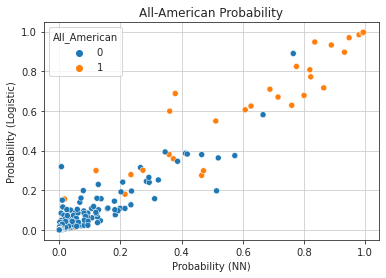

In [62]:
test_scatter = sns.scatterplot(data = test_df, x = "phat_nn", y = "phat_logis",
                hue = "All_American")
test_scatter.set(xlabel = "Probability (NN)",
                 ylabel = "Probability (Logistic)",
                 title = "All-American Probability")
plt.show()

We can also apply the logistic regression model to this year's players. Many of the results are similar, like how Edey, Tubelis, and Wilson are ahead of everyone else. However, there are a couple interesting results. Liam Robbins and Darius McGee both have high probabilities despite the fact that they likely will not be named All-Americans at the end of the season. Both play for teams that are not in the NCAA Tournament at-large picture, telling us that the logistic regression model probably does not give as much importance to team performance as the neural network does. 

In [63]:
data23_pred_lr = logReg.predict_proba(st_data23_x)
data23["phat_logis"] = data23_pred_lr[:, 1]
data23_results = data23[["Player","Season","School","phat_logis"]]
data23_results = data23_results.sort_values(by = "phat_logis", ascending = False)
print(data23_results.head(20))

                     Player  Season       School  phat_logis
48838             Zach Edey    2023       Purdue    0.996063
3805        Azuolas Tubelis    2023      Arizona    0.835075
21173          Jalen Wilson    2023       Kansas    0.808402
45813  Trayce Jackson-Davis    2023      Indiana    0.799519
32564         Marcus Sasser    2023      Houston    0.753495
5174         Brandon Miller    2023      Alabama    0.725795
29161        Keyonte George    2023       Baylor    0.537205
49474          Adama Sanogo    2023  Connecticut    0.537187
31008          Liam Robbins    2023   Vanderbilt    0.501838
14663            Drew Timme    2023      Gonzaga    0.490138
32881       Markquis Nowell    2023   Kansas St.    0.468629
28510         Kendric Davis    2023      Memphis    0.426058
32401           Marcus Carr    2023        Texas    0.407706
11595         Darius McGhee    2023      Liberty    0.362590
627            Adam Flagler    2023       Baylor    0.322272
47762        Wade Taylor

McGee and Robbins are two of the players with the greatest descrepancies in probability from the two models. They are joined by Kris Murray, Oumar Ballo, and Kobe Brown as players that are likely to be All-Americans by one model but unlikely by the other. 

In [65]:
big_diff = data23[["Player","School","phat_nn","phat_logis"]]
big_diff["diff"] = abs(big_diff["phat_nn"] - big_diff["phat_logis"])
print(big_diff.sort_values(by = "diff", ascending = False).head())

              Player      School   phat_nn  phat_logis      diff
11595  Darius McGhee     Liberty  0.000330    0.362590  0.362260
29788    Kris Murray        Iowa  0.437799    0.167580  0.270219
37791    Oumar Ballo     Arizona  0.397959    0.187749  0.210210
31008   Liam Robbins  Vanderbilt  0.317167    0.501838  0.184670
29542     Kobe Brown    Missouri  0.410941    0.240397  0.170545


<ipython-input-65-b0c688c3f37e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_diff["diff"] = abs(big_diff["phat_nn"] - big_diff["phat_logis"])


One advantage of a logistic regression is that it is easier to see which variables are the msot important in determining the probability. The bar graph shows which variables have the greatest impact in the regression. Blue columns note variables with a positive coefficient (greater is better) while orange bars represent variables with a negative coefficient (lower is better). We can do this because all of the independent variables are in a standardized scale, so the coefficients can be compared. In this context, the coefficient can be interpreted as how much the log odds would increase (or decrease) with a one standard deviation increase in the statistic. 

In [66]:
coeffs = logReg.coef_[0]
variables = list(train_df.columns[3:ncol+2])

coeff_df = pd.DataFrame(list(zip(variables, coeffs)), columns = ["Variable","Coefficient"])
coeff_df["Sign"] = np.select([coeff_df["Coefficient"] > 0, coeff_df["Coefficient"] < 0], 
                             ["Positive","Negative"])
coeff_df = coeff_df.assign(Coefficient = lambda x: abs(x["Coefficient"]))
coeff_df = coeff_df.sort_values(by = "Coefficient", ascending = False)
coeff_df

,Variable,Coefficient,Sign
0,FG2M,1.812996,Positive
2,FG3M,1.793715,Positive
12,WP,1.466951,Positive
4,FTM,1.237520,Positive
8,AST,0.962909,Positive
16,sos_opp_d,0.926847,Negative
13,adj_o,0.780288,Positive
14,adj_d,0.600626,Negative
15,sos_opp_o,0.545772,Positive
7,DREB,0.521441,Positive


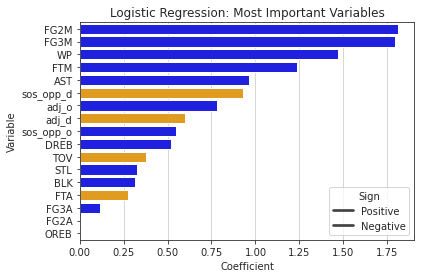

In [67]:
cols = ['blue' if x == "Positive" else 'orange' for x in coeff_df.Sign]

coeff_bar = sns.barplot(data = coeff_df, orient = 'h',
                        x = 'Coefficient', y = 'Variable',
                        palette = cols)
coeff_bar.set(title = "Logistic Regression: Most Important Variables")
coeff_bar.legend(title = "Sign",
                 loc = "lower right",
                 labels = ["Positive","Negative"])
plt.show()

The graph reinforces some of the findings earlier, in that scoring and team performance are the most important factors in predicting All-Americans as 2-point makes, 3-point makes, win percentage, and free throws made are the 4 variables with the greatest coefficients. In additions, we can see that playmaking matters as assists is next. 

There were some things that surprised me, though. First, both 2-point field goals made and 3-point field goals made had the same coefficient even though 3's are worth more. This could indicate that 2-point scoring has increased importance in college. Additionally, shooting efficiency did not seem to matter very much as attempts in all shooting categories had very low coefficients (although this could be due to collinearity). Lastly, it seems that team offense is more important than team defense in this context since adjusted offensive efficiency and strength of opponent defense were more important than adjusted defensive efficiency and strength of opponent offense. 

After investigating both the neural network and logistic regression, it seems like the neural network came up with the best predictions. Finally, we can see the projected All-American teams. If the season ended today, the first-team All-Americans would likely consist of Edey, Wilson, Tubelis, Jackson-Davis, and Miller. Unfortunately, this doesn't account for positions as it is unlikely all 5 of these players will make the real first-team since all are forwards or centers. Marcus Sasser, Keyonte George, and Markquis Nowell headline the guards with rank highest. The player with the greatest All-American probability by a wide margin is Zach Edey, which is good since he is the NCAA player of the year favorite right now. In addition, all of the teams listed below except for Ohio State are on track to make the NCAA Tournament, reinforcing the belief that All-Americans play on high quality teams. 

Watch out for these guys in the tournament come March!

In [68]:
aa23 = data23[["Player","School","phat_nn"]]
aa23["Rk"] = aa23["phat_nn"].rank(ascending = False, method = 'min')
aa23 = aa23[aa23["Rk"] < 16].sort_values(by = "Rk")

cond = [(aa23["Rk"] > 0) & (aa23["Rk"] < 6),
        (aa23["Rk"] > 5) & (aa23["Rk"] < 11),
        (aa23["Rk"] > 10) & (aa23["Rk"] < 16)]
choice = ["First-Team", "Second-Team", "Third-Team"]
aa23["All-American"] = np.select(cond, choice)
aa23 = aa23[["Rk","All-American","Player","School","phat_nn"]]
print(aa23)

         Rk All-American                Player       School   phat_nn
48838   1.0   First-Team             Zach Edey       Purdue  0.984472
21173   2.0   First-Team          Jalen Wilson       Kansas  0.885775
3805    3.0   First-Team       Azuolas Tubelis      Arizona  0.868469
45813   4.0   First-Team  Trayce Jackson-Davis      Indiana  0.768406
5174    5.0   First-Team        Brandon Miller      Alabama  0.754298
32564   6.0  Second-Team         Marcus Sasser      Houston  0.644999
49474   7.0  Second-Team          Adama Sanogo  Connecticut  0.618253
29161   8.0  Second-Team        Keyonte George       Baylor  0.608215
32881   9.0  Second-Team       Markquis Nowell   Kansas St.  0.505917
14663  10.0  Second-Team            Drew Timme      Gonzaga  0.504127
29788  11.0   Third-Team           Kris Murray         Iowa  0.437799
5861   12.0   Third-Team      Brice Sensabaugh     Ohio St.  0.426707
32401  13.0   Third-Team           Marcus Carr        Texas  0.426264
29542  14.0   Third-

<ipython-input-68-06bfda66e462>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aa23["Rk"] = aa23["phat_nn"].rank(ascending = False, method = 'min')
